In [1]:
%matplotlib inline
# %matplotlib notebook # Does not work 
import pickle 
import numpy as np
from matplotlib import pyplot as plt
import json
from hpbandster.core.result import logged_results_to_HBS_result
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime

In [2]:
def load_results(file):
    with open(file, 'rt') as f_in:
        results = []
        for line in f_in:
#             line = line.strip('\n')
            results.append(json.loads(line))
        
        return {'loss_data': [x[3]['loss'] for x in results if x[1] == 100], # Get only runs on 100% of data
#         return {'loss_data': [x[3]['loss'] for x in results], # Get only runs on 100% of data
                'dataset': file.split('/')[1].split('_')[0],
                'hpo_method': file.split('/')[2].split('_')[2],
                'times': [x[2] for x in results]
               }
#         return results

In [3]:
def plot_results(*plots, default=0, n=0, time_flag=False):
        
    plt.figure()
    plt.clf()

    plt.title('RS vs BOHB HPO methods on ' + plots[0]['dataset'].upper() + ' validation set' )
    
    plt.axhline(y=default, color='r', linestyle='-', label = 'Default hp')
    
    for plot_data in plots:
    
        pp = PdfPages(plot_data['dataset'] + '_hpo_curve.pdf')
        pp.savefig()
#         y_results = [1 - min(plot_data['loss_data'][0:i+1]) for i,x in enumerate(plot_data['loss_data'])]
        y_results = [1 - min(plot_data['loss_data'][0:i+1]) for i,x in enumerate(plot_data['loss_data'])]
    
        if time_flag:
            time_diff = plot_data['times'][-1]['finished'] - plot_data['times'][0]['submitted']
            idx = list(np.linspace(0, time_diff, num=len(y_results)))
        
            idx = [x/3600 for x in idx]
            plt.xlabel('wallclock-time [hr]', fontsize = 13)
        else:
            idx = list(range(0,len(y_results)))
            plt.xlabel('# iterations', fontsize = 13)
        
        if plot_data['dataset'] == 'tvqa':            
            plt.ylabel('Loss/Accuracy', fontsize = 13)
        else:
            plt.ylabel('Loss/MAP', fontsize = 13)
        plt.plot(idx[n:], y_results[n:], label = plot_data['hpo_method'].upper())
        
#     plt.plot([x/hour for x in incumbent_bohb['times_finished']], incumbent_bohb['losses'])
    pp.savefig()
    plt.legend()
    plt.show()
    pp.close()

In [4]:
bio_bohb_file = './bioasq_dir/hpo_results_bohb/results.json'
bio_rs_file = './bioasq_dir/hpo_results_rs/results.json'
rob_bohb_file = './robust_dir/hpo_results_bohb/results.json'
rob_rs_file = './robust_dir/hpo_results_rs/results.json'

In [5]:
bio_bohb_results = load_results(bio_bohb_file)
bio_rs_results = load_results(bio_rs_file)
rob_bohb_results = load_results(rob_bohb_file)
rob_rs_results = load_results(rob_rs_file)

In [6]:
bio_bohb_results.keys()

dict_keys(['loss_data', 'dataset', 'hpo_method', 'times'])

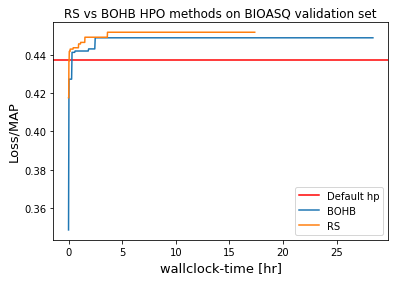

In [7]:
plot_results(bio_bohb_results,bio_rs_results, default=0.4371, n=0, time_flag=True)

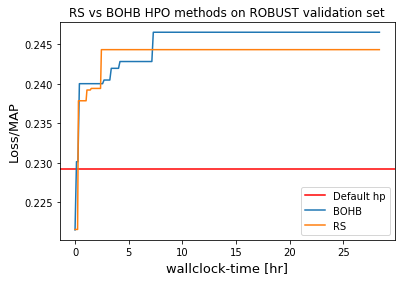

In [8]:
plot_results(rob_bohb_results,rob_rs_results, default=0.2292, n=0, time_flag=True)

In [9]:
now = datetime.now()
timestamp = datetime.timestamp(now)

bio_bohb_dir = './bioasq_dir/hpo_results_bohb/'
bio_rs_dir = './bioasq_dir/hpo_results_rs/'
rob_bohb_dir = './robust_dir/hpo_results_bohb/'
rob_rs_dir = './robust_dir/hpo_results_rs/'

analyzed_results = {'bio_bohb': logged_results_to_HBS_result(bio_bohb_dir),
                    'bio_rs': logged_results_to_HBS_result(bio_rs_dir),
                    'rob_bohb': logged_results_to_HBS_result(rob_bohb_dir),
                    'rob_rs': logged_results_to_HBS_result(rob_rs_dir)
                    }

analyzed_results_file = './deep_relevance_hpo_results_' + str(timestamp) + '.pkl'

pickle.dump( analyzed_results_file, open(analyzed_results_file, 'wb'))